Pulling wind data from ERDAPP and plotting it for various stations along the strait after filtering and rotating. Also has a quick frequency plot at the very bottom. 

In [1]:
import netCDF4 as nc
import numpy as np
import xarray as xr
from salishsea_tools import nc_tools, viz_tools, grid_tools, geo_tools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.signal as signal
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
nemo_ji = np.array([(400, 25), (350,35), (300,40), (240,120), (250,50), (200,120), (150,150), 
                    (100,170), (50,180)]) + (335,115)

In [3]:
grid = xr.open_dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
atmos_grid = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')

In [4]:
winds_data = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')

In [5]:
NEMO_bathymetry = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')

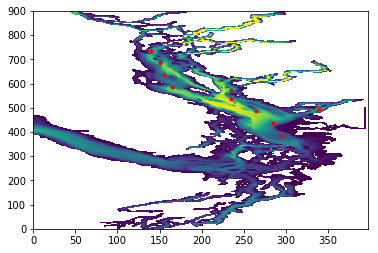

In [26]:
NEMO_bathy = NEMO_bathymetry.variables['Bathymetry']

plt.pcolormesh(NEMO_bathy)
for point in nemo_ji:
    plt.plot(point[1], point[0], 'r.')

In [88]:
point = nemo_ji[0]
nemo_lon = grid.nav_lon.isel(y=point[0], x=point[1])
nemo_lat = grid.nav_lat.isel(y=point[0], x=point[1])
nemo_lon_lat = (np.asscalar(nemo_lon.values), np.asscalar(nemo_lat))
atmos_ji = geo_tools.find_closest_model_point(
        nemo_lon_lat[0], nemo_lon_lat[1],
        atmos_grid.longitude.values - 360, atmos_grid.latitude.values,
        grid = "GEM2.5")
u_wind_ts = (winds_data.u_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
v_wind_ts = (winds_data.v_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
rotated_u_winds, rotated_v_winds = viz_tools.rotate_vel(u_wind_ts.values, 
                                                       v_wind_ts.values, origin = 'map' )

In [101]:
import scipy.signal as signal
N  = 1    # Filter order
Wn = 1/24 # Cutoff frequency
B, A = signal.butter(N, Wn)

In [102]:
windf = signal.filtfilt(B,A,rotated_v_winds)

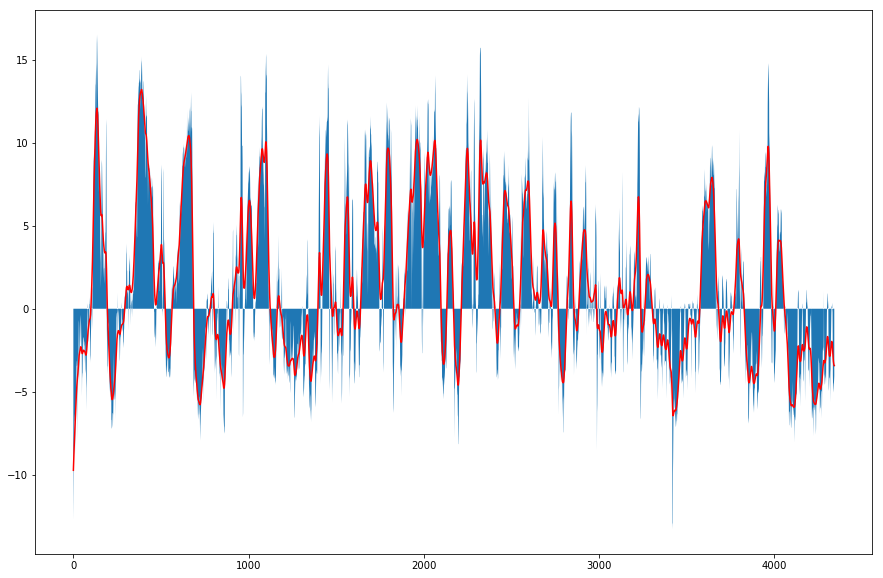

In [103]:
fig,ax = plt.subplots(figsize=(15,10))   #N=1, Wn = 1/24
ax.fill_between(range(4345), rotated_v_winds)
ax.plot(range(4345), windf, 'r-')

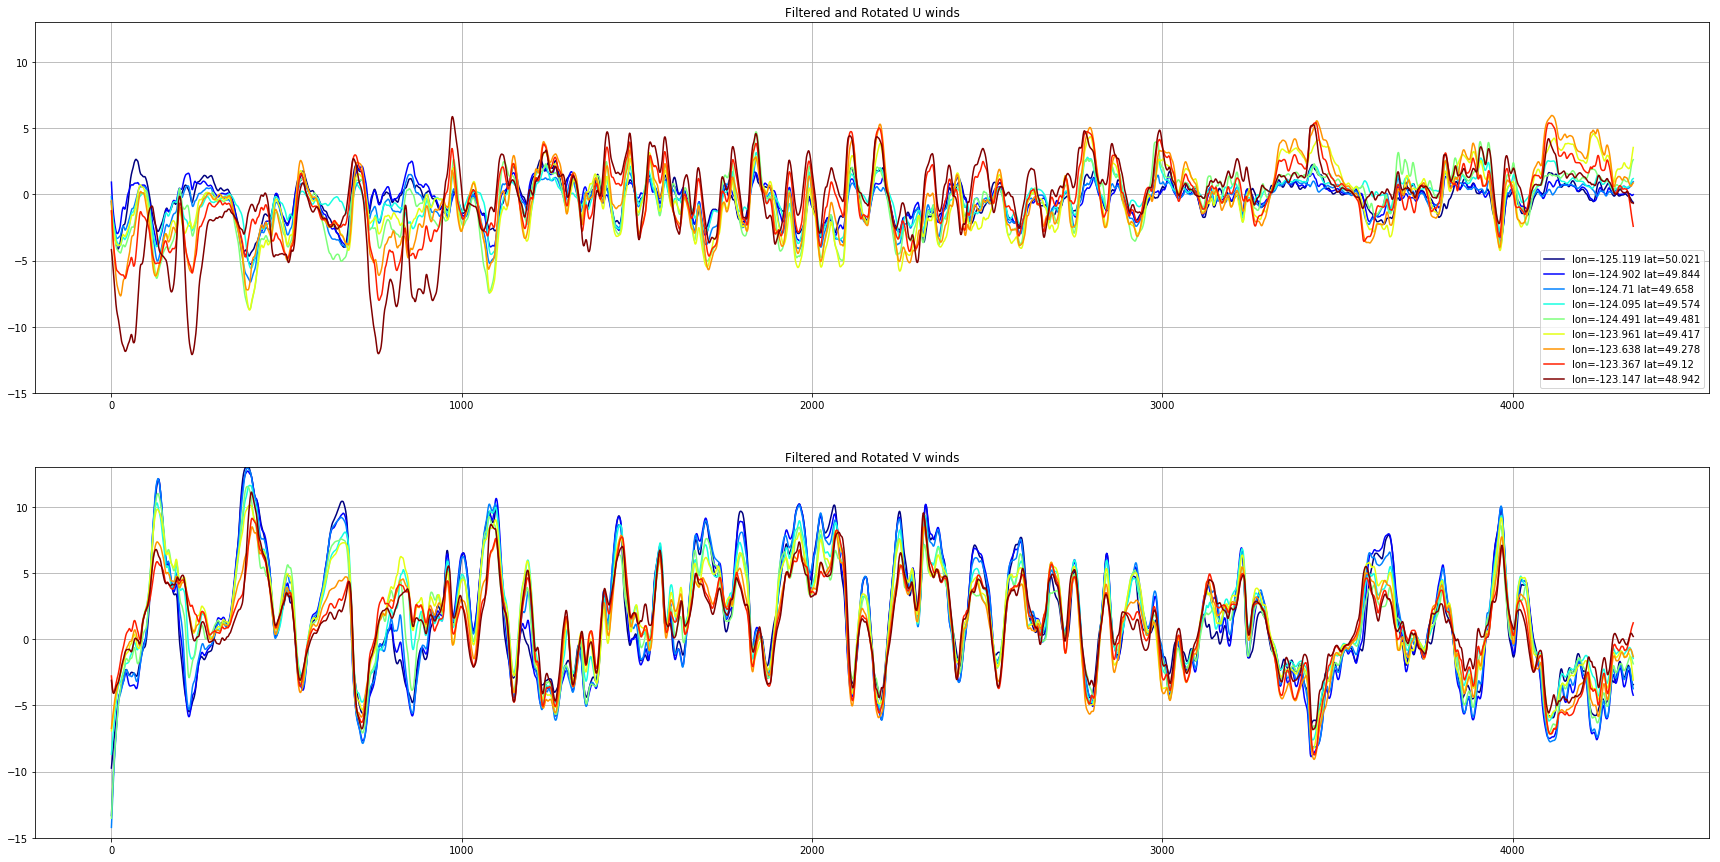

In [184]:
time_slice = slice('2017-01-01 12:00:00', '2017-07-01 12:00:00')
N = 1
Wn = 1/24
B, A = signal.butter(N,Wn)
colours = cm.jet(np.linspace(0,1,9))
fig,axs = plt.subplots(2,1, figsize=(30,15))
for point, colour in zip(nemo_ji, colours):
    nemo_lon = grid.nav_lon.isel(y=point[0], x=point[1])
    nemo_lat = grid.nav_lat.isel(y=point[0], x=point[1])
    nemo_lon_lat = (np.asscalar(nemo_lon.values), np.asscalar(nemo_lat))
    atmos_ji = geo_tools.find_closest_model_point(
        nemo_lon_lat[0], nemo_lon_lat[1],
        atmos_grid.longitude.values - 360, atmos_grid.latitude.values,
        grid = "GEM2.5")
    u_wind_ts = (winds_data.u_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    v_wind_ts = (winds_data.v_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    rotated_u_winds, rotated_v_winds = viz_tools.rotate_vel(u_wind_ts.values, 
                                                       v_wind_ts.values, origin = 'map' )
    windfu = signal.filtfilt(B,A, rotated_u_winds)
    windfv = signal.filtfilt(B,A,rotated_v_winds)
    axs[0].plot(range(4345), windfu, color = colour, label = 'lon='+
                str(np.round(nemo_lon_lat[0],3))
                +" lat="+str(np.round(nemo_lon_lat[1],3)))
    axs[0].set_title('Filtered and Rotated U winds')
    axs[1].plot(range(4345), windfv, color = colour, label = 'lon='+
                str(np.round(nemo_lon_lat[0],3))
                +" lat="+str(np.round(nemo_lon_lat[1],3))) 
    axs[1].set_title('Filtered and Rotated V winds')
axs[0].legend(loc = 'lower right')
axs[0].set_ylim(-15,13)
axs[1].set_ylim(-15,13)
axs[0].grid()
axs[1].grid()

In [37]:
300/24

12.5

With butterworth low pass filter, n=1, cutoff frequency = 1/24

Times when V winds are very different in North and South
* hour = 100-300
* hour = 600-700ish
* hour = 800-900
* hour = 1900-2100
* hour = 3500-3600

In general, higher v winds occur in the north.

Times when u winds are siginificant
* hour = 0-300 in the south
* hour = 700-950 in the south

In general, u winds are below 5, except in the first 1.25 months of the year. 

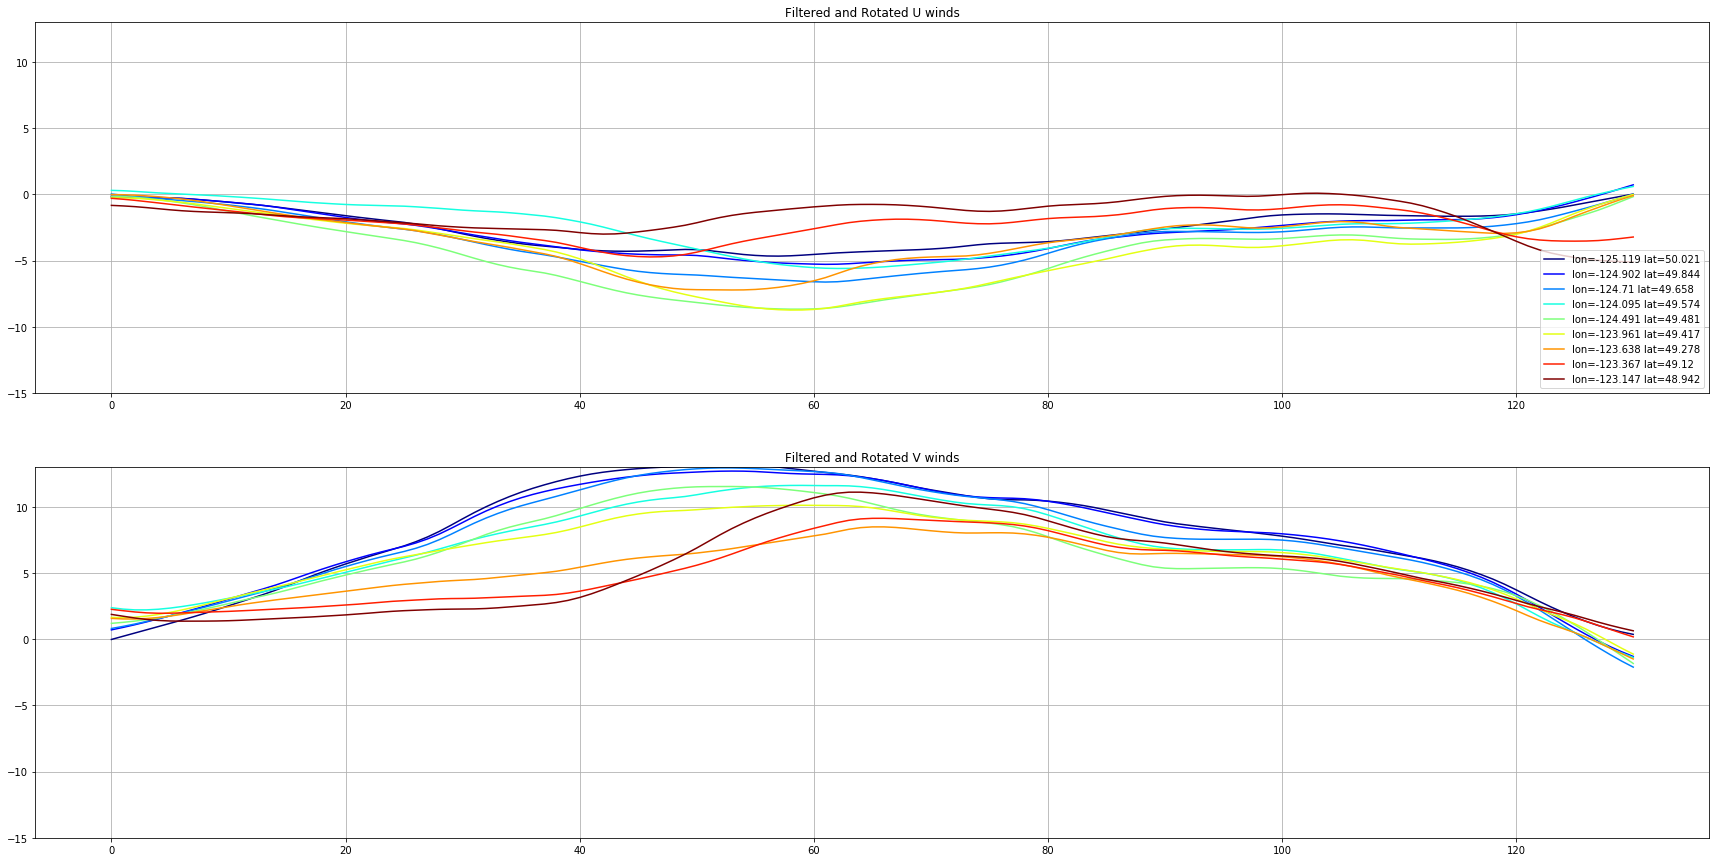

In [43]:
time_slice = slice('2017-01-15 12:00:00', '2017-01-20 22:00:00')
N = 1
Wn = 1/24
B, A = signal.butter(N,Wn)
colours = cm.jet(np.linspace(0,1,9))
fig,axs = plt.subplots(2,1, figsize=(30,15))
for point, colour in zip(nemo_ji, colours):
    nemo_lon = grid.nav_lon.isel(y=point[0], x=point[1])
    nemo_lat = grid.nav_lat.isel(y=point[0], x=point[1])
    nemo_lon_lat = (np.asscalar(nemo_lon.values), np.asscalar(nemo_lat))
    atmos_ji = geo_tools.find_closest_model_point(
        nemo_lon_lat[0], nemo_lon_lat[1],
        atmos_grid.longitude.values - 360, atmos_grid.latitude.values,
        grid = "GEM2.5")
    u_wind_ts = (winds_data.u_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    v_wind_ts = (winds_data.v_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    rotated_u_winds, rotated_v_winds = viz_tools.rotate_vel(u_wind_ts.values, 
                                                       v_wind_ts.values, origin = 'map' )
    windfu = signal.filtfilt(B,A, rotated_u_winds)
    windfv = signal.filtfilt(B,A,rotated_v_winds)
    axs[0].plot(range(len(windfu)), windfu, color = colour, label = 'lon='+
                str(np.round(nemo_lon_lat[0],3))
                +" lat="+str(np.round(nemo_lon_lat[1],3)))
    axs[0].set_title('Filtered and Rotated U winds')
    axs[1].plot(range(len(windfv)), windfv, color = colour, label = 'lon='+
                str(np.round(nemo_lon_lat[0],3))
                +" lat="+str(np.round(nemo_lon_lat[1],3))) 
    axs[1].set_title('Filtered and Rotated V winds')
axs[0].legend(loc = 'lower right')
axs[0].set_ylim(-15,13)
axs[1].set_ylim(-15,13)
axs[0].grid()
axs[1].grid()

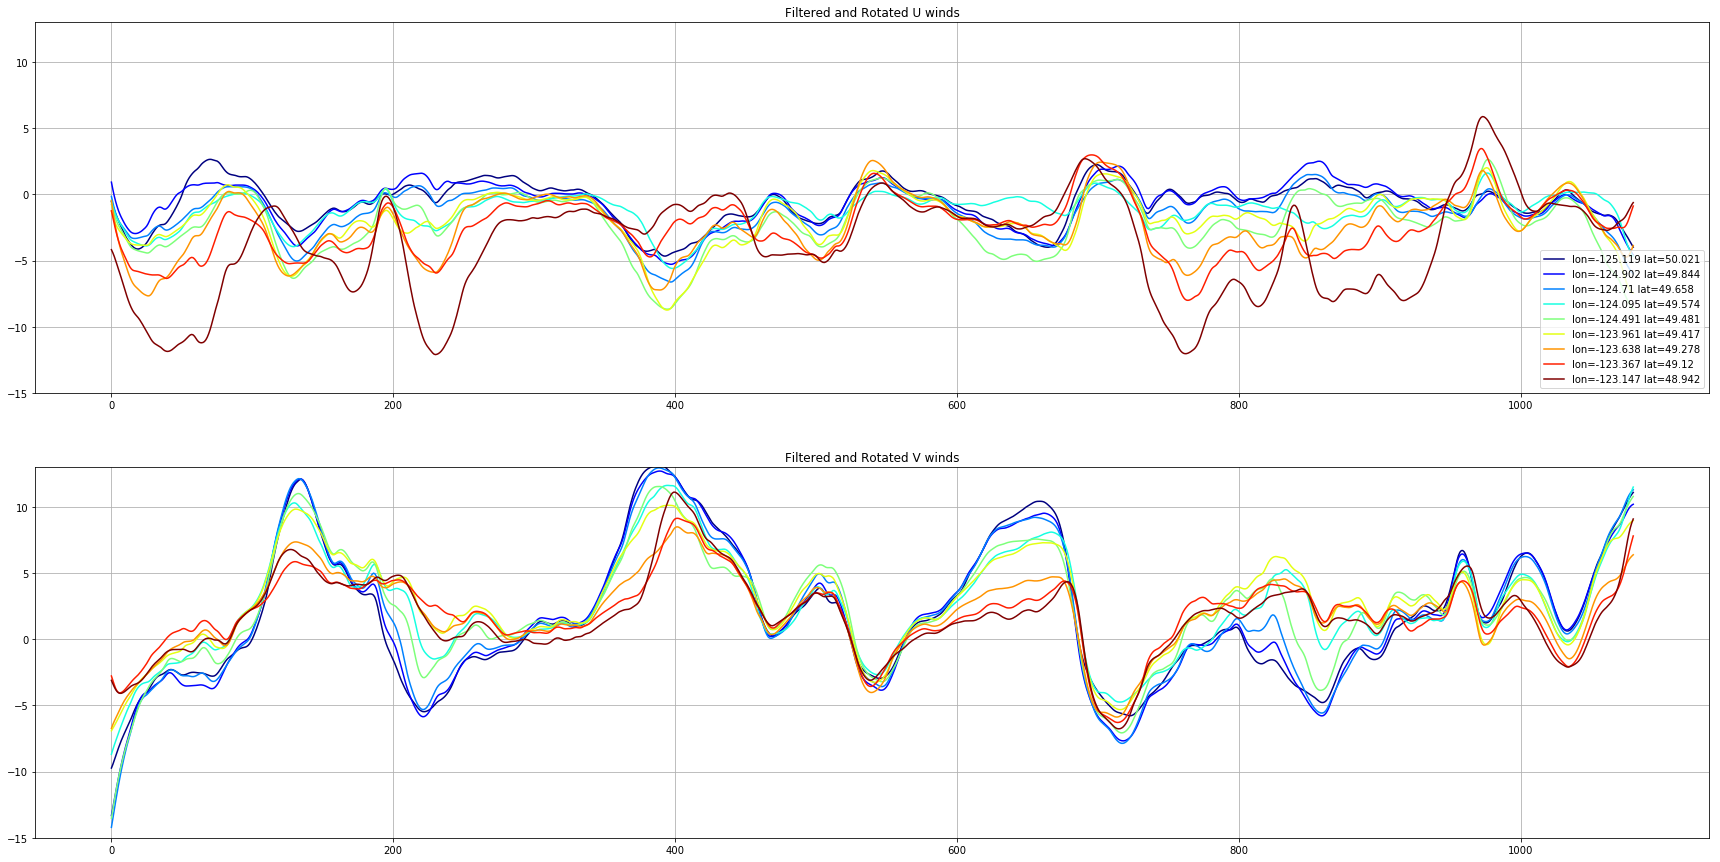

In [190]:
time_slice = slice('2017-01-01 12:00:00', '2017-02-15 12:00:00')
N = 1
Wn = 1/24
B, A = signal.butter(N,Wn)
colours = cm.jet(np.linspace(0,1,9))
fig,axs = plt.subplots(2,1, figsize=(30,15))
for point, colour in zip(nemo_ji, colours):
    nemo_lon = grid.nav_lon.isel(y=point[0], x=point[1])
    nemo_lat = grid.nav_lat.isel(y=point[0], x=point[1])
    nemo_lon_lat = (np.asscalar(nemo_lon.values), np.asscalar(nemo_lat))
    atmos_ji = geo_tools.find_closest_model_point(
        nemo_lon_lat[0], nemo_lon_lat[1],
        atmos_grid.longitude.values - 360, atmos_grid.latitude.values,
        grid = "GEM2.5")
    u_wind_ts = (winds_data.u_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    v_wind_ts = (winds_data.v_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    rotated_u_winds, rotated_v_winds = viz_tools.rotate_vel(u_wind_ts.values, 
                                                       v_wind_ts.values, origin = 'map' )
    windfu = signal.filtfilt(B,A, rotated_u_winds)
    windfv = signal.filtfilt(B,A,rotated_v_winds)
    axs[0].plot(range(1081), windfu, color = colour, label = 'lon='+
                str(np.round(nemo_lon_lat[0],3))
                +" lat="+str(np.round(nemo_lon_lat[1],3)))
    axs[0].set_title('Filtered and Rotated U winds')
    axs[1].plot(range(1081), windfv, color = colour, label = 'lon='+
                str(np.round(nemo_lon_lat[0],3))
                +" lat="+str(np.round(nemo_lon_lat[1],3))) 
    axs[1].set_title('Filtered and Rotated V winds')
axs[0].legend(loc = 'lower right')
axs[0].set_ylim(-15,13)
axs[1].set_ylim(-15,13)
axs[0].grid()
axs[1].grid()

#### U winds
* Strong u winds in first two days of January in the south
 * Again in the second week, first 1.5 weeks of Febuary
* Mostly below +/- 5

#### V winds
* Lots of wind 100-300 (~ 8 days) in the north while south has < 5
* shorter winds hour = 375 - 425. North still has stronger winds. (Jan 15-17)
* More difference in hour 600-700 (~4 days). North has much more. (entering Febuary)
* hour 800-900
 * North has almost opposite winds (+5 vs -5)
* Short highish (5) winds in Febuary (~2 days). North has more winds

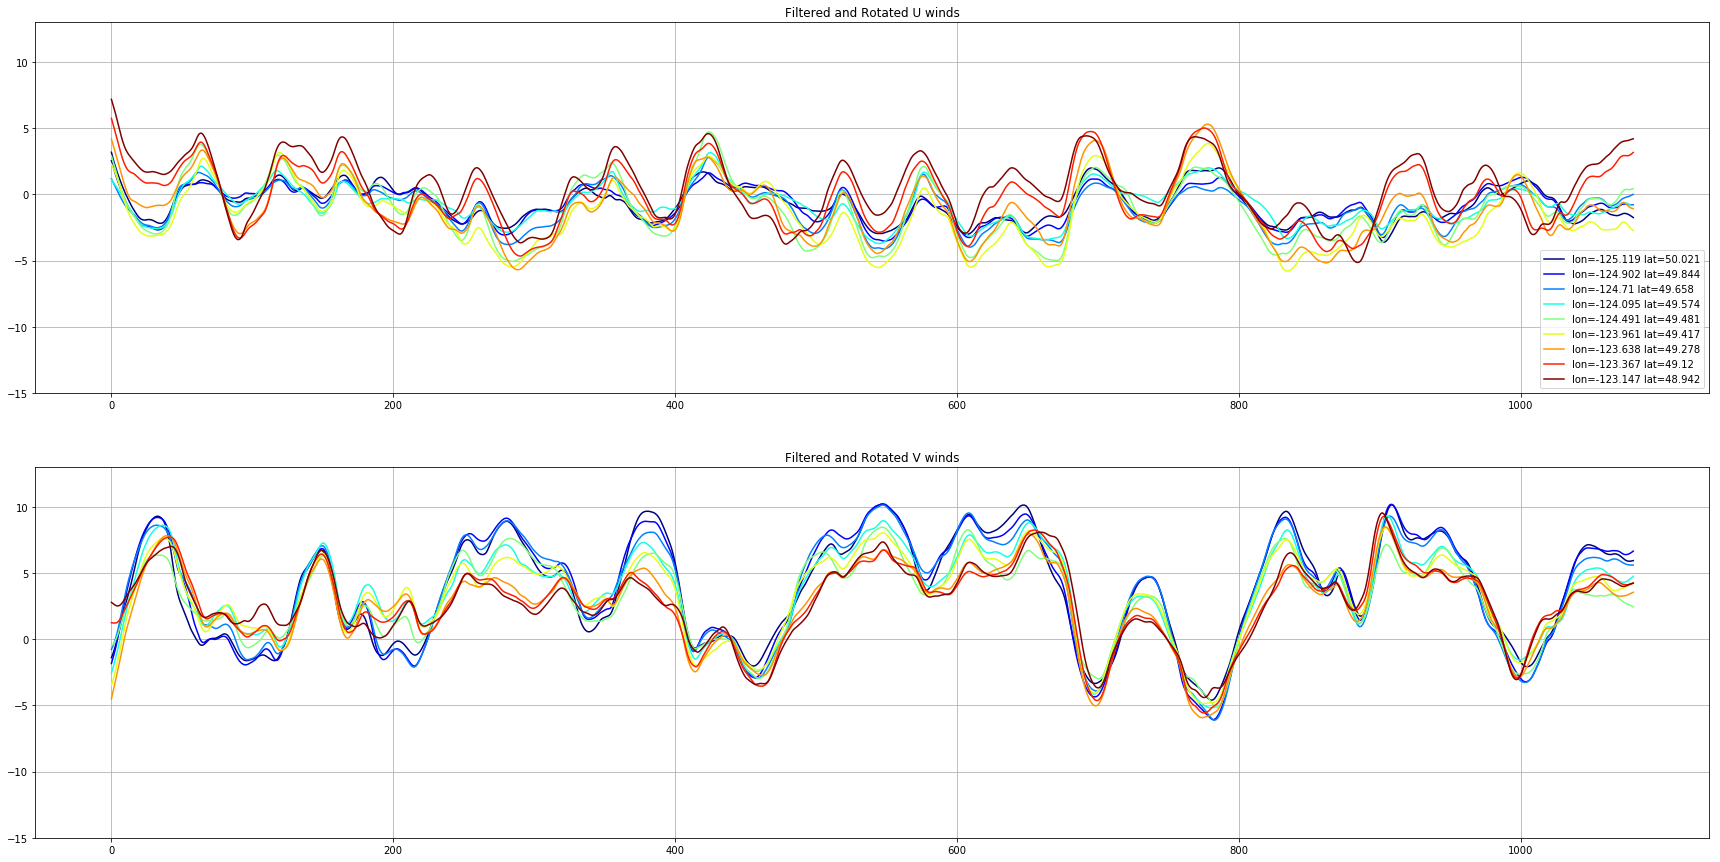

In [195]:
time_slice = slice('2017-03-01 12:00:00', '2017-04-15 12:00:00')
N = 1
Wn = 1/24
B, A = signal.butter(N,Wn)
colours = cm.jet(np.linspace(0,1,9))
fig,axs = plt.subplots(2,1, figsize=(30,15))
for point, colour in zip(nemo_ji, colours):
    nemo_lon = grid.nav_lon.isel(y=point[0], x=point[1])
    nemo_lat = grid.nav_lat.isel(y=point[0], x=point[1])
    nemo_lon_lat = (np.asscalar(nemo_lon.values), np.asscalar(nemo_lat))
    atmos_ji = geo_tools.find_closest_model_point(
        nemo_lon_lat[0], nemo_lon_lat[1],
        atmos_grid.longitude.values - 360, atmos_grid.latitude.values,
        grid = "GEM2.5")
    u_wind_ts = (winds_data.u_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    v_wind_ts = (winds_data.v_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    rotated_u_winds, rotated_v_winds = viz_tools.rotate_vel(u_wind_ts.values, 
                                                       v_wind_ts.values, origin = 'map' )
    windfu = signal.filtfilt(B,A, rotated_u_winds)
    windfv = signal.filtfilt(B,A,rotated_v_winds)
    axs[0].plot(range(len(windfu)), windfu, color = colour, label = 'lon='+
                str(np.round(nemo_lon_lat[0],3))
                +" lat="+str(np.round(nemo_lon_lat[1],3)))
    axs[0].set_title('Filtered and Rotated U winds')
    axs[1].plot(range(len(windfv)), windfv, color = colour, label = 'lon='+
                str(np.round(nemo_lon_lat[0],3))
                +" lat="+str(np.round(nemo_lon_lat[1],3))) 
    axs[1].set_title('Filtered and Rotated V winds')
axs[0].legend(loc = 'lower right')
axs[0].set_ylim(-15,13)
axs[1].set_ylim(-15,13)
axs[0].grid()
axs[1].grid()

#### V winds
* Almost opposite winds in north vs south in hour 75-125, 190-210 (first week of March)
* North has almost double in hour 250-325 (~3 days) (March 10-13ish)
 * again in hour 350-400 (~2 days)
* some difference in hour 500-700. North is not quite 2x the south (end of March)
* hour 700-750, 800-850 (~2 days)
 * North has ~2x the south
* hour 900-950 (~2 days) (second week of April)
 * North is not quite 2x south

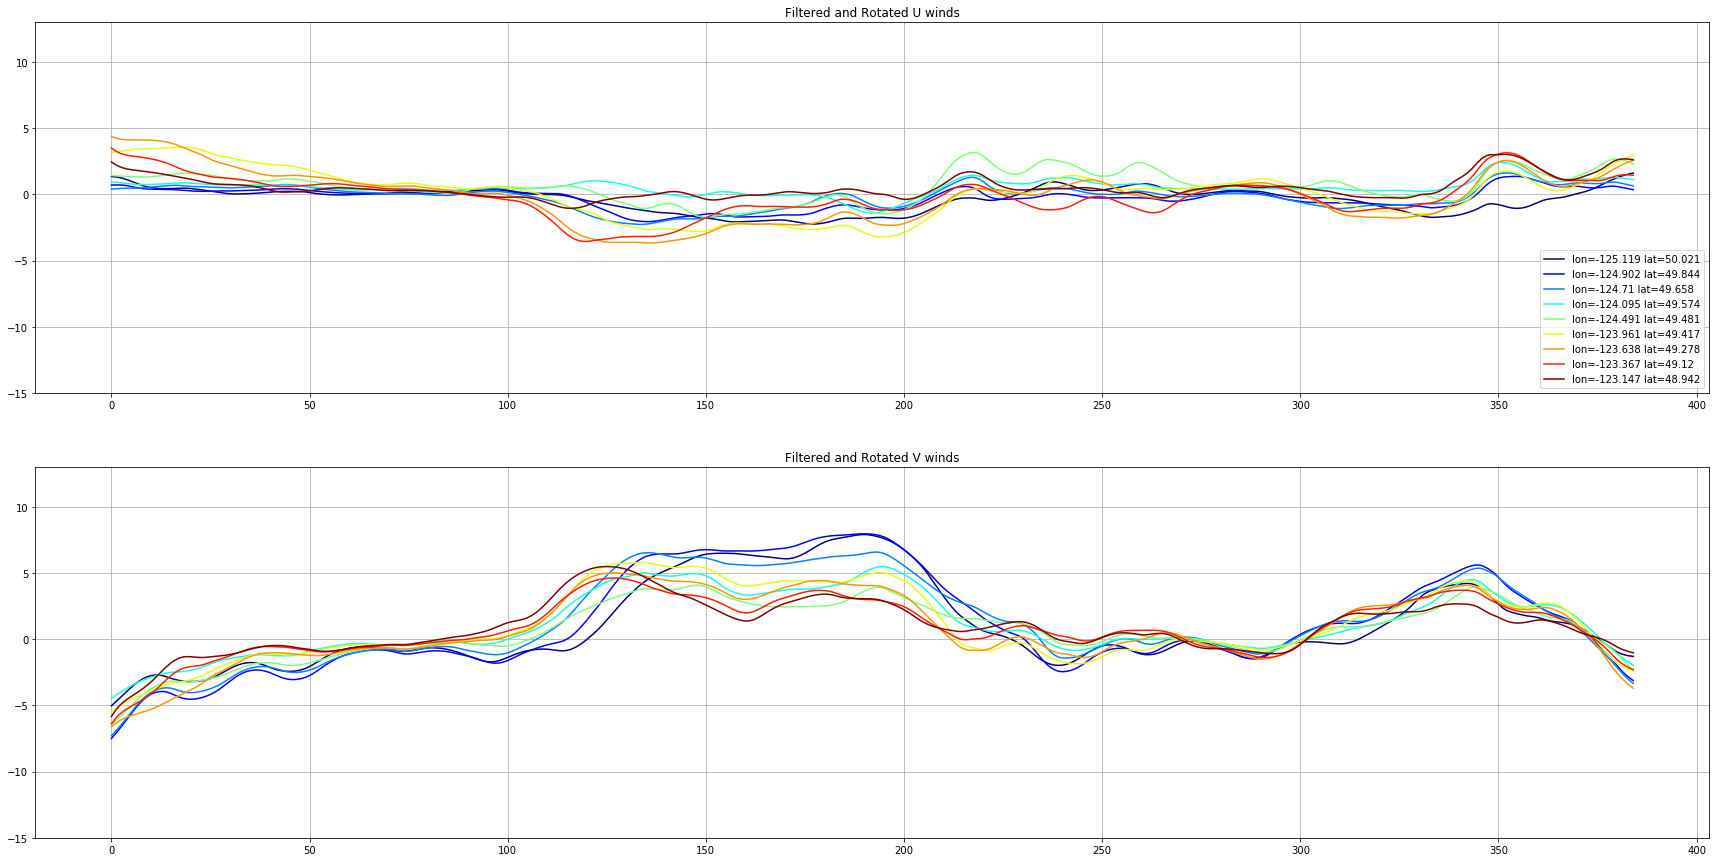

In [222]:
time_slice = slice('2017-05-25 12:00:00', '2017-06-10 12:00:00')
N = 1
Wn = 1/24
B, A = signal.butter(N,Wn)
colours = cm.jet(np.linspace(0,1,9))
fig,axs = plt.subplots(2,1, figsize=(30,15))
for point, colour in zip(nemo_ji, colours):
    nemo_lon = grid.nav_lon.isel(y=point[0], x=point[1])
    nemo_lat = grid.nav_lat.isel(y=point[0], x=point[1])
    nemo_lon_lat = (np.asscalar(nemo_lon.values), np.asscalar(nemo_lat))
    atmos_ji = geo_tools.find_closest_model_point(
        nemo_lon_lat[0], nemo_lon_lat[1],
        atmos_grid.longitude.values - 360, atmos_grid.latitude.values,
        grid = "GEM2.5")
    u_wind_ts = (winds_data.u_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    v_wind_ts = (winds_data.v_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    rotated_u_winds, rotated_v_winds = viz_tools.rotate_vel(u_wind_ts.values, 
                                                       v_wind_ts.values, origin = 'map' )
    windfu = signal.filtfilt(B,A, rotated_u_winds)
    windfv = signal.filtfilt(B,A,rotated_v_winds)
    axs[0].plot(range(len(windfu)), windfu, color = colour, label = 'lon='+
                str(np.round(nemo_lon_lat[0],3))
                +" lat="+str(np.round(nemo_lon_lat[1],3)))
    axs[0].set_title('Filtered and Rotated U winds')
    axs[1].plot(range(len(windfv)), windfv, color = colour, label = 'lon='+
                str(np.round(nemo_lon_lat[0],3))
                +" lat="+str(np.round(nemo_lon_lat[1],3))) 
    axs[1].set_title('Filtered and Rotated V winds')
axs[0].legend(loc = 'lower right')
axs[0].set_ylim(-15,13)
axs[1].set_ylim(-15,13)
axs[0].grid()
axs[1].grid()

* May 30 - June 3 (hour = 125-225)
 * North has stronger winds (~2x)
* One day wind event June 9 (hour = 330-360)
 * North ~2x south

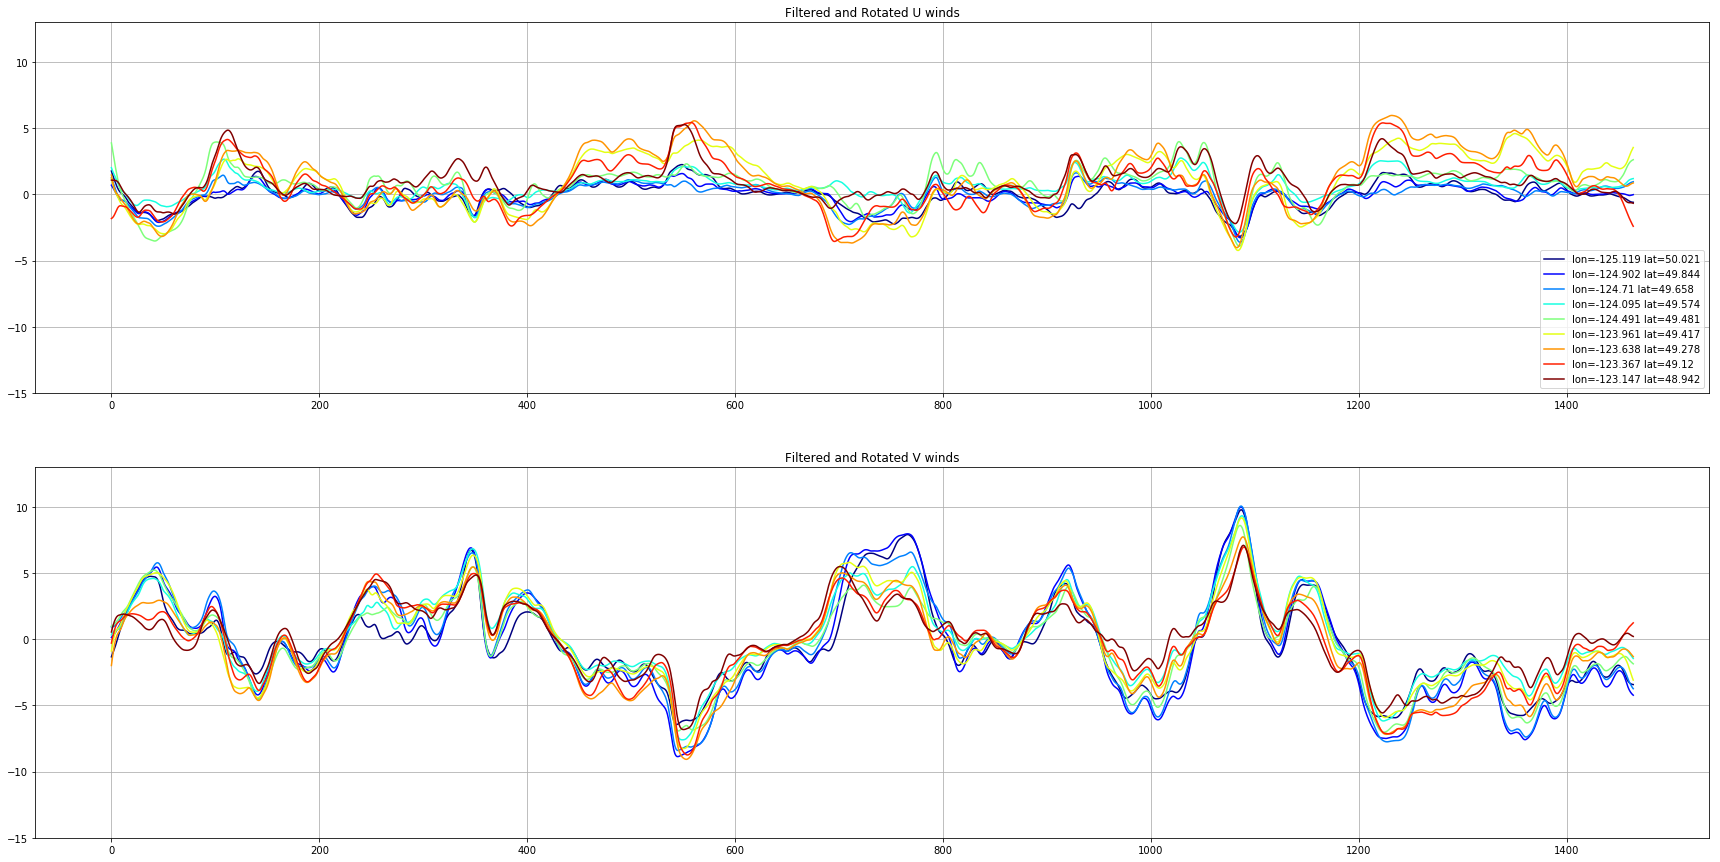

In [6]:
time_slice = slice('2017-05-01 12:00:00', '2017-07-01 12:00:00')
N = 1
Wn = 1/24
B, A = signal.butter(N,Wn)
colours = cm.jet(np.linspace(0,1,9))
fig,axs = plt.subplots(2,1, figsize=(30,15))
for point, colour in zip(nemo_ji, colours):
    nemo_lon = grid.nav_lon.isel(y=point[0], x=point[1])
    nemo_lat = grid.nav_lat.isel(y=point[0], x=point[1])
    nemo_lon_lat = (np.asscalar(nemo_lon.values), np.asscalar(nemo_lat))
    atmos_ji = geo_tools.find_closest_model_point(
        nemo_lon_lat[0], nemo_lon_lat[1],
        atmos_grid.longitude.values - 360, atmos_grid.latitude.values,
        grid = "GEM2.5")
    u_wind_ts = (winds_data.u_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    v_wind_ts = (winds_data.v_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    rotated_u_winds, rotated_v_winds = viz_tools.rotate_vel(u_wind_ts.values, 
                                                       v_wind_ts.values, origin = 'map' )
    windfu = signal.filtfilt(B,A, rotated_u_winds)
    windfv = signal.filtfilt(B,A,rotated_v_winds)
    axs[0].plot(range(len(windfu)), windfu, color = colour, label = 'lon='+
                str(np.round(nemo_lon_lat[0],3))
                +" lat="+str(np.round(nemo_lon_lat[1],3)))
    axs[0].set_title('Filtered and Rotated U winds')
    axs[1].plot(range(len(windfv)), windfv, color = colour, label = 'lon='+
                str(np.round(nemo_lon_lat[0],3))
                +" lat="+str(np.round(nemo_lon_lat[1],3))) 
    axs[1].set_title('Filtered and Rotated V winds')
axs[0].legend(loc = 'lower right')
axs[0].set_ylim(-15,13)
axs[1].set_ylim(-15,13)
axs[0].grid()
axs[1].grid()

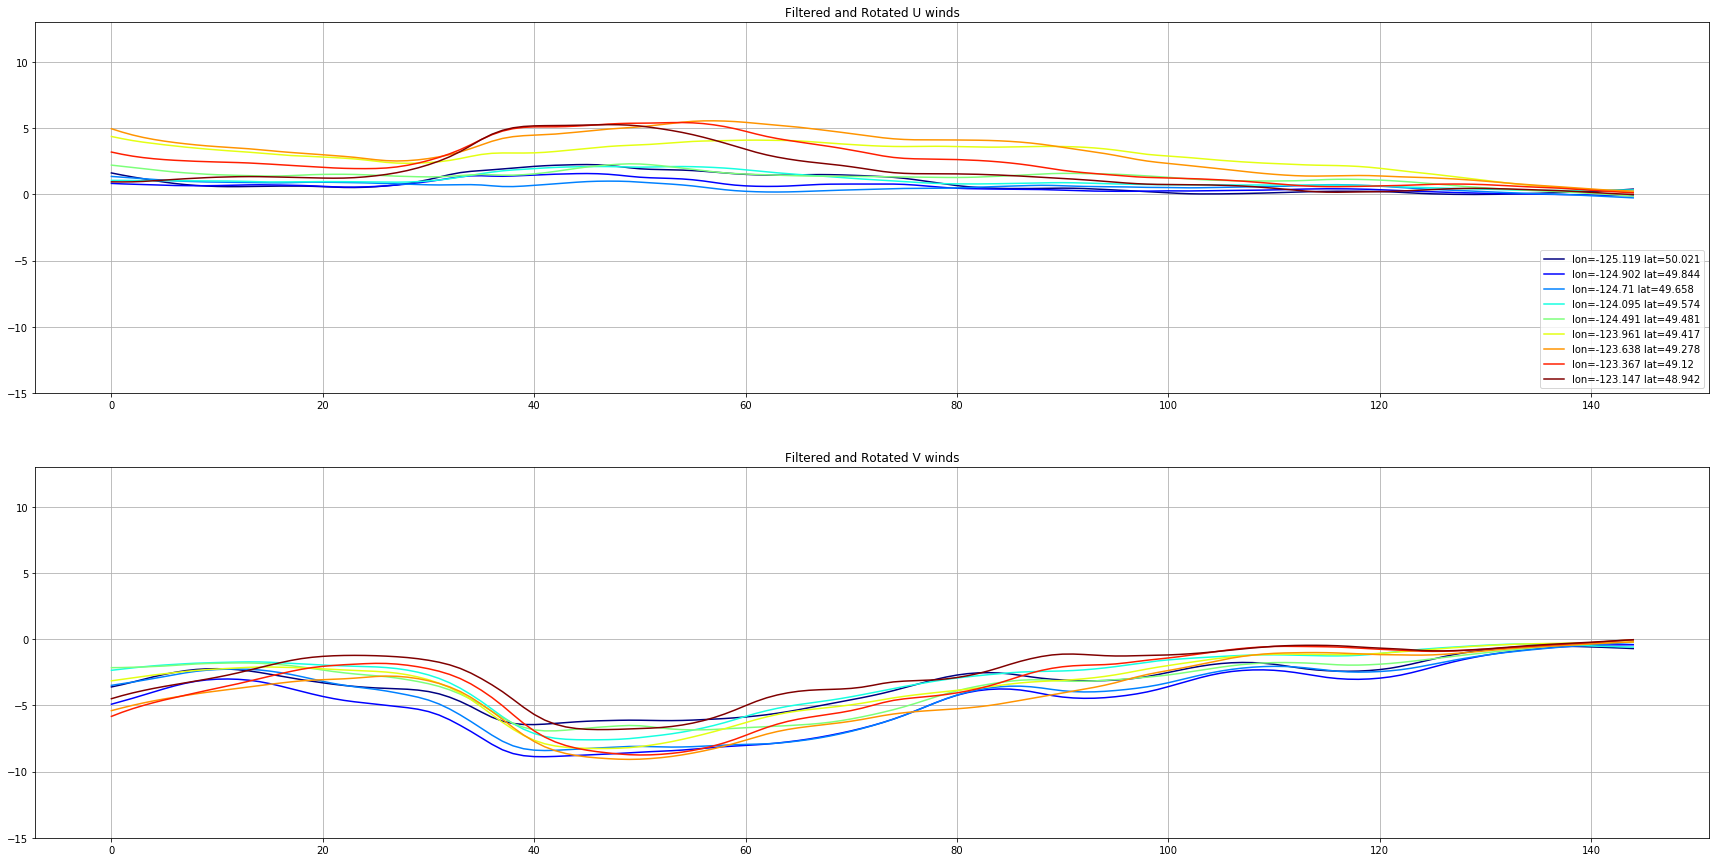

In [10]:
time_slice = slice('2017-05-22 12:00:00', '2017-05-28 12:00:00')
N = 1
Wn = 1/24
B, A = signal.butter(N,Wn)
colours = cm.jet(np.linspace(0,1,9))
fig,axs = plt.subplots(2,1, figsize=(30,15))
for point, colour in zip(nemo_ji, colours):
    nemo_lon = grid.nav_lon.isel(y=point[0], x=point[1])
    nemo_lat = grid.nav_lat.isel(y=point[0], x=point[1])
    nemo_lon_lat = (np.asscalar(nemo_lon.values), np.asscalar(nemo_lat))
    atmos_ji = geo_tools.find_closest_model_point(
        nemo_lon_lat[0], nemo_lon_lat[1],
        atmos_grid.longitude.values - 360, atmos_grid.latitude.values,
        grid = "GEM2.5")
    u_wind_ts = (winds_data.u_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    v_wind_ts = (winds_data.v_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    rotated_u_winds, rotated_v_winds = viz_tools.rotate_vel(u_wind_ts.values, 
                                                       v_wind_ts.values, origin = 'map' )
    windfu = signal.filtfilt(B,A, rotated_u_winds)
    windfv = signal.filtfilt(B,A,rotated_v_winds)
    axs[0].plot(range(len(windfu)), windfu, color = colour, label = 'lon='+
                str(np.round(nemo_lon_lat[0],3))
                +" lat="+str(np.round(nemo_lon_lat[1],3)))
    axs[0].set_title('Filtered and Rotated U winds')
    axs[1].plot(range(len(windfv)), windfv, color = colour, label = 'lon='+
                str(np.round(nemo_lon_lat[0],3))
                +" lat="+str(np.round(nemo_lon_lat[1],3))) 
    axs[1].set_title('Filtered and Rotated V winds')
axs[0].legend(loc = 'lower right')
axs[0].set_ylim(-15,13)
axs[1].set_ylim(-15,13)
axs[0].grid()
axs[1].grid()

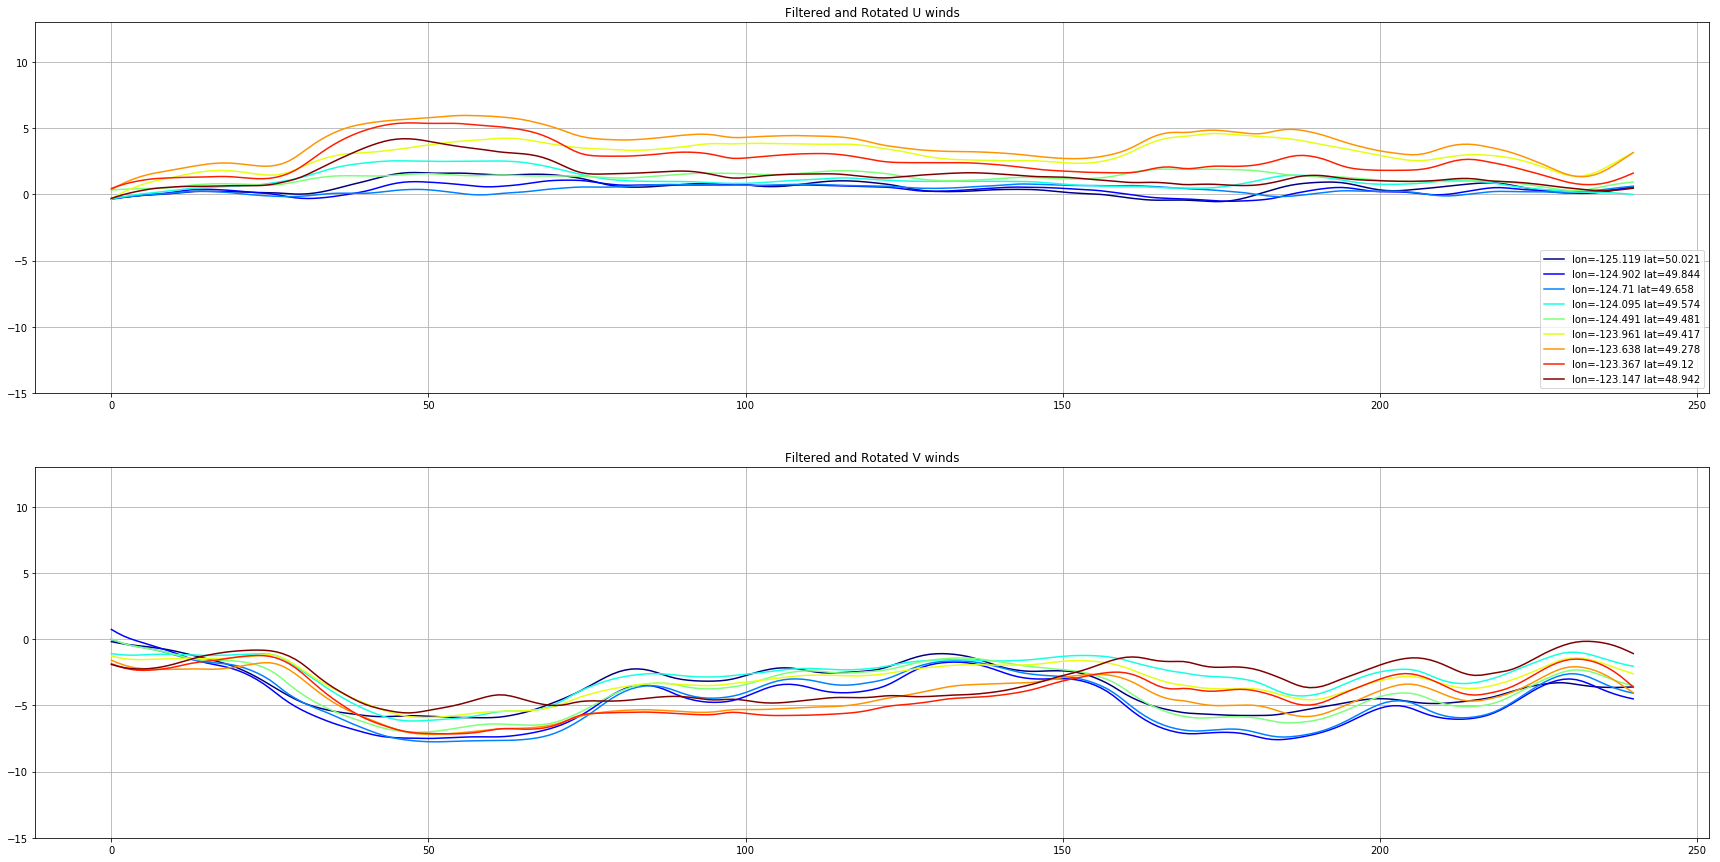

In [19]:
time_slice = slice('2017-06-19 12:00:00', '2017-06-29 12:00:00')
N = 1
Wn = 1/24
B, A = signal.butter(N,Wn)
colours = cm.jet(np.linspace(0,1,9))
fig,axs = plt.subplots(2,1, figsize=(30,15))
for point, colour in zip(nemo_ji, colours):
    nemo_lon = grid.nav_lon.isel(y=point[0], x=point[1])
    nemo_lat = grid.nav_lat.isel(y=point[0], x=point[1])
    nemo_lon_lat = (np.asscalar(nemo_lon.values), np.asscalar(nemo_lat))
    atmos_ji = geo_tools.find_closest_model_point(
        nemo_lon_lat[0], nemo_lon_lat[1],
        atmos_grid.longitude.values - 360, atmos_grid.latitude.values,
        grid = "GEM2.5")
    u_wind_ts = (winds_data.u_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    v_wind_ts = (winds_data.v_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    rotated_u_winds, rotated_v_winds = viz_tools.rotate_vel(u_wind_ts.values, 
                                                       v_wind_ts.values, origin = 'map' )
    windfu = signal.filtfilt(B,A, rotated_u_winds)
    windfv = signal.filtfilt(B,A,rotated_v_winds)
    axs[0].plot(range(len(windfu)), windfu, color = colour, label = 'lon='+
                str(np.round(nemo_lon_lat[0],3))
                +" lat="+str(np.round(nemo_lon_lat[1],3)))
    axs[0].set_title('Filtered and Rotated U winds')
    axs[1].plot(range(len(windfv)), windfv, color = colour, label = 'lon='+
                str(np.round(nemo_lon_lat[0],3))
                +" lat="+str(np.round(nemo_lon_lat[1],3))) 
    axs[1].set_title('Filtered and Rotated V winds')
axs[0].legend(loc = 'lower right')
axs[0].set_ylim(-15,13)
axs[1].set_ylim(-15,13)
axs[0].grid()
axs[1].grid()

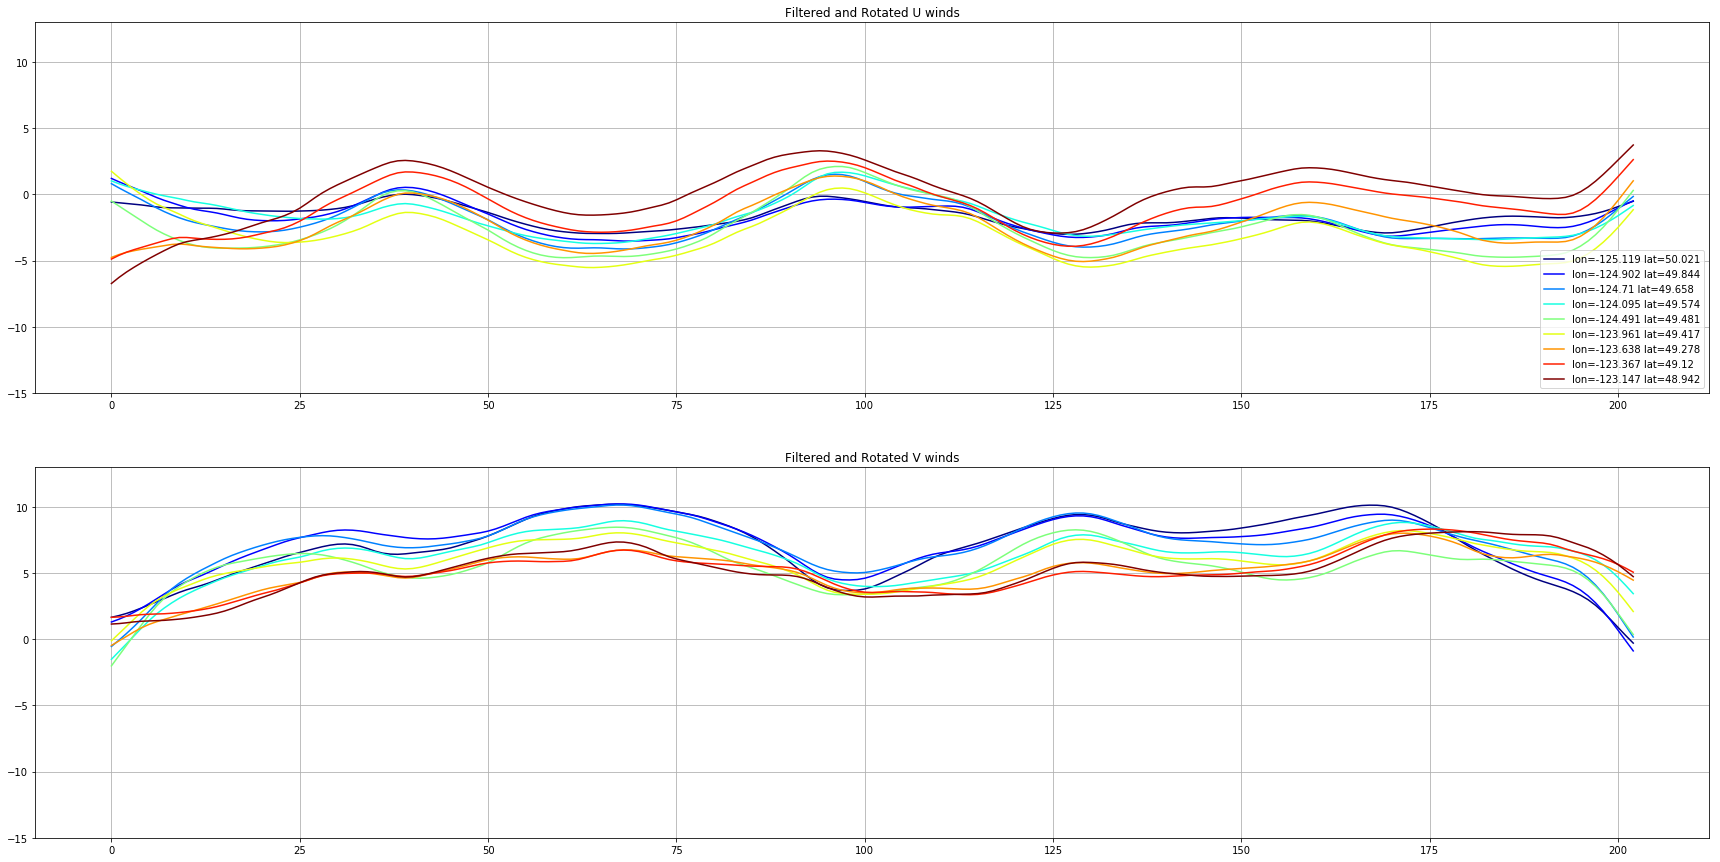

In [33]:
time_slice = slice('2017-03-21 12:00:00', '2017-03-29 22:00:00')
N = 1
Wn = 1/24
B, A = signal.butter(N,Wn)
colours = cm.jet(np.linspace(0,1,9))
fig,axs = plt.subplots(2,1, figsize=(30,15))
for point, colour in zip(nemo_ji, colours):
    nemo_lon = grid.nav_lon.isel(y=point[0], x=point[1])
    nemo_lat = grid.nav_lat.isel(y=point[0], x=point[1])
    nemo_lon_lat = (np.asscalar(nemo_lon.values), np.asscalar(nemo_lat))
    atmos_ji = geo_tools.find_closest_model_point(
        nemo_lon_lat[0], nemo_lon_lat[1],
        atmos_grid.longitude.values - 360, atmos_grid.latitude.values,
        grid = "GEM2.5")
    u_wind_ts = (winds_data.u_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    v_wind_ts = (winds_data.v_wind
                 .isel(gridY=atmos_ji[0], gridX=atmos_ji[1])
                 .sel(time=time_slice))
    rotated_u_winds, rotated_v_winds = viz_tools.rotate_vel(u_wind_ts.values, 
                                                       v_wind_ts.values, origin = 'map' )
    windfu = signal.filtfilt(B,A, rotated_u_winds)
    windfv = signal.filtfilt(B,A,rotated_v_winds)
    axs[0].plot(range(len(windfu)), windfu, color = colour, label = 'lon='+
                str(np.round(nemo_lon_lat[0],3))
                +" lat="+str(np.round(nemo_lon_lat[1],3)))
    axs[0].set_title('Filtered and Rotated U winds')
    axs[1].plot(range(len(windfv)), windfv, color = colour, label = 'lon='+
                str(np.round(nemo_lon_lat[0],3))
                +" lat="+str(np.round(nemo_lon_lat[1],3))) 
    axs[1].set_title('Filtered and Rotated V winds')
axs[0].legend(loc = 'lower right')
axs[0].set_ylim(-15,13)
axs[1].set_ylim(-15,13)
axs[0].grid()
axs[1].grid()

In [34]:
202/240

0.8416666666666667

In [21]:
24*6/4

36.0

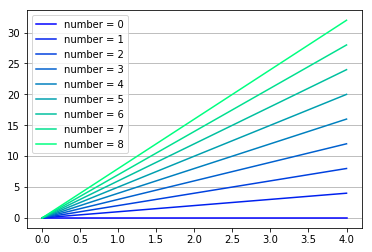

In [185]:
fig,ax=plt.subplots()
colours = cm.winter(np.linspace(0,1,9))
for n, colour in zip(range(10), colours):
    ax.plot(np.arange(0,5), n*np.arange(0,5), color = colour, label = 'number = '+ str(n))
ax.legend()
ax.yaxis.grid()

In [119]:
v_freq = np.abs(np.fft.fft(rotated_v_winds- rotated_v_winds.mean()) )  

In [120]:
freq = np.fft.fftfreq(v_freq.shape[0], d=1/24)

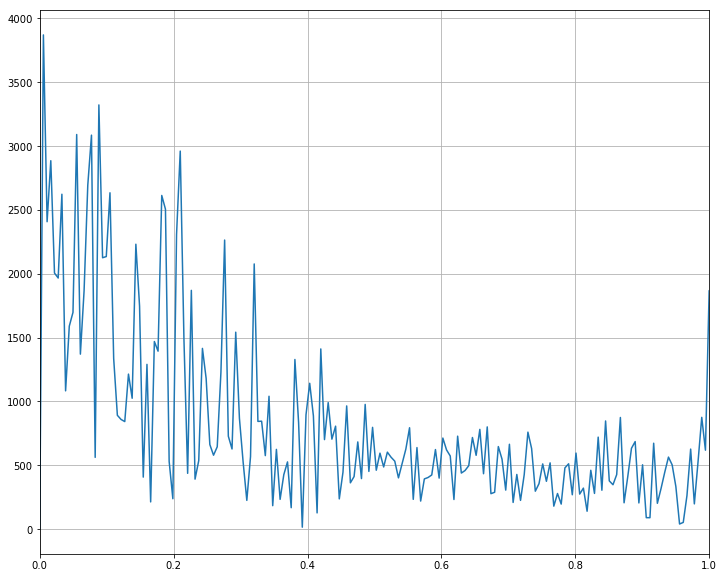

In [121]:
fig,ax = plt.subplots(figsize=(12,10))
ax.plot(np.fft.fftshift(freq), np.fft.fftshift(v_freq))
ax.set_xlim(0,1)
ax.grid('on')